In [56]:
import pickle
import pandas as pd
import numpy as np
import nltk
import gensim 
import string
from gensim.models import LdaModel
import spacy
from spacy.tokens import Token
from spacy.lang.en.stop_words import STOP_WORDS  # import stop 
from gensim.corpora import Dictionary
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
nlp = spacy.load("en_core_web_sm")
pd.set_option('display.max_colwidth', 500)

In [2]:
with open('outputs.pickle', 'rb') as handle:
    outputs = pickle.load(handle)
train = outputs['df_train_merge']
test = outputs['df_test_merge']

In [3]:
test.columns

Index(['Date', 'Time', 'Training/Test', 'Title', 'Link', 'Abstract',
       'tweet_id', 'external_url', 'tweet_found', 'user_name', 'mentions',
       'medias', 'hashtags', 'in_reply_to_status_id',
       'in_reply_to_screen_name', 'in_reply_to_status_text',
       'external_url_title', 'New_Title', 'ab_clean', 'numbers', 'zero_length',
       'nouns', 'neg_noun_I', 'neg_noun_you', 'neg_noun_i', 'neg_noun_me',
       'neg_noun_we', 'neg_noun_they', 'neg_noun_It', 'neg_noun_You', 'nnp',
       'word_recall', 'word_alert', 'word_allergy', 'word_outbreak',
       'hashtag_RECALL', 'hashtag_Recall', 'hashtag_SmartNews',
       'mention_googlenews', 'num_words', 'user_name_words',
       'user_name_word_News', 'has_media', 'question_mark', 'preds',
       'pred_probs', 'has_recall'],
      dtype='object')

In [4]:
type(test.ab_clean[0])

list

# 新增Predicted Event ID列

In [5]:
test['Predicted Event ID'] = np.NaN

 # 移除爬取到的title中一些XXX on Twitter等无用词

In [ ]:
# def remove_pre(text):
#     text = str(text)
#     index = text.find(":")
#     if index != -1:
#         return text[index + 1:]
#     else:
#         return text

In [ ]:
# test['New_Title'] = test['New_Title'].apply(remove_pre)

# 第一次分词：从整个TestSet中找出垃圾词

In [ ]:
# def getTokens_noGarbage(all_command):
#     handle_all_command = []
#     lines = all_command.tolist()
#     stopwords = set(nltk.corpus.stopwords.words("english"))
#     table = str.maketrans("","",string.punctuation)
#     for line in lines:
#         line = " ".join([word for word in str(line).split(" ") if '@' not in word and 'http' not in word and "RT" not in word])
#         tokens = nltk.word_tokenize(line)
#         tokens = [w.lower() for w in tokens]
#         tokens = [w.translate(table) for w in tokens]
#         tokens = [w for w in tokens if w.isalpha()]
#         tokens = [w for w in tokens if w not in stopwords]
#         handle_all_command.append(tokens)
#     return handle_all_command

In [ ]:
# %time tokens = getTokens_noGarbage(test["New_Title"]) 

In [6]:
tokens = test['ab_clean']

## 将词频小于等于3的或者单词长度<3的单词作为垃圾词添

In [7]:
from collections import Counter

freq = Counter()
for ab in tokens:
    freq.update(ab)
    
garbage = []
for k, v in freq.items():
    if v <= 3 or len(k) < 3:
        garbage.append(k)

# 对数据进行二次分词，这次剔除掉垃圾词

In [9]:
%time test['ab_clean'] = test['ab_clean'].apply(lambda text: [xx for xx in text if xx not in garbage])
test['len'] = [len(to) for to in test['ab_clean']]

CPU times: user 40.8 s, sys: 35.4 ms, total: 40.8 s
Wall time: 40.9 s


# 将所有分词个数<=3的record的预测值置False

In [10]:
print(len(test[test['preds'] == True]), len(test[(test['preds'] == True) & (test['len'] > 3)]))

2289 2272


In [11]:
test.loc[test['len'] <= 3, 'preds'] = np.False_
len(test[test['preds'] == True])

2272

# 找出事件中词频较高并且没有主题意义的单词

In [12]:
freq2 = Counter()
for ab in test.loc[test['preds'] == True, 'ab_clean']:
    freq2.update(ab)
sorted(freq2.items(), key=lambda x: x[1], reverse=True)[0: 200]

[('recall', 2677),
 ('salmonella', 1583),
 ('flour', 1201),
 ('pillsbury', 1123),
 ('twitter', 958),
 ('turkey', 614),
 ('food', 525),
 ('butterball', 514),
 ('concern', 500),
 ('product', 468),
 ('ground', 468),
 ('pound', 399),
 ('case', 360),
 ('news', 342),
 ('contamination', 339),
 ('possible', 335),
 ('fear', 211),
 ('alert', 176),
 ('risk', 157),
 ('publix', 157),
 ('dixie', 147),
 ('winn', 143),
 ('purpose', 132),
 ('unbleached', 128),
 ('safety', 125),
 ('company', 124),
 ('announce', 118),
 ('issue', 117),
 ('contaminate', 112),
 ('sell', 112),
 ('new', 108),
 ('chicken', 107),
 ('rice', 101),
 ('trace', 97),
 ('select', 96),
 ('undeclared', 93),
 ('allergen', 92),
 ('raw', 92),
 ('ton', 87),
 ('hometown', 81),
 ('outbreak', 78),
 ('check', 77),
 ('nationwide', 70),
 ('chef', 63),
 ('nearly', 63),
 ('boyardee', 62),
 ('march', 61),
 ('schwarzengrund', 61),
 ('brand', 58),
 ('misbrand', 55),
 ('package', 55),
 ('cbs', 54),
 ('fry', 52),
 ('store', 51),
 ('health', 48),
 ('volu

In [13]:
no_topic_means_words = ["food", "twitter", "recall", "news", "publix", "due"]

In [20]:
test.loc[test['preds'] == True, 'ab_clean'] = [[xx for xx in text if xx not in no_topic_means_words] for text in test[test['preds'] == True]['ab_clean']]

# 用LDA模型把preds为True的record进行话题分析

In [23]:
all_sent = test[test['preds'] == True]['ab_clean']
dic = Dictionary(all_sent)
corpus = [dic.doc2bow(text) for text in all_sent]

# %time lda = LdaModel(corpus=corpus, id2word=dic, num_topics=14, passes=100, random_state=42) 

In [ ]:
# mallet_path = 'mallet-2.0.8/bin/mallet' # update this path

# 通过计算coherence来选出得分高的模型

In [24]:
from gensim.models import CoherenceModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=10, step=1):
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit + 1, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics,alpha="auto", passes=10, random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [25]:
%time model_list, coherence_values = compute_coherence_values(dictionary=dic, corpus=corpus, texts=all_sent, start=10, limit=20, step=1)


CPU times: user 1min 15s, sys: 746 ms, total: 1min 16s
Wall time: 1min 17s


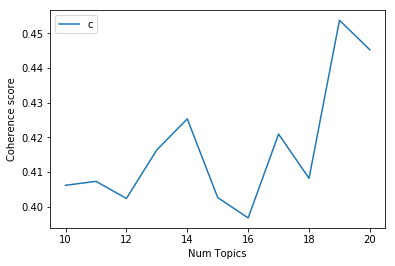

In [27]:
import matplotlib.pyplot as plt

limit=20; start=10; step=1;
x = range(start, limit + 1, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# 取19作为topic数

In [28]:
lda = model_list[-2]

In [47]:
word_top5_dic={}
for each in lda.print_topics(num_topics=19, num_words=10):
    word_top5_dic[each[0]] = [x[x.find('*') + 2: len(x) - 1] for x in each[1].split(' + ')[0:5]]
word_top5_dic

{0: ['turkey', 'salmonella', 'butterball', 'ground', 'pound'],
 1: ['fear', 'nbc', 'cbs', 'new', 'york'],
 2: ['pillsbury', 'flour', 'salmonella', 'possible', 'contamination'],
 3: ['trace', 'flour', 'pillsbury', 'bag', 'salmonella'],
 4: ['turkey', 'butterball', 'ground', 'salmonella', 'fear'],
 5: ['health', 'allergy', 'follow', 'know', 'life'],
 6: ['turkey', 'butterball', 'salmonella', 'ground', 'possible'],
 7: ['product', 'allergen', 'undeclared', 'chicken', 'rice'],
 8: ['flour', 'pillsbury', 'salmonella', 'concern', 'case'],
 9: ['today', 'share', 'allergy', 'let', 'equipment'],
 10: ['salmonella', 'coli', 'cheese', 'french', 'safety'],
 11: ['chef', 'boyardee', 'chicken', 'department', 'pound'],
 12: ['march', 'info', 'live', 'asda', 'allergy'],
 13: ['action', 'policy', 'great', 'watch', 'flourrecall'],
 14: ['date', 'april', 'foodsafety', 'new', 'metal'],
 15: ['product', 'sausage', 'tamper', 'pork', 'contamination'],
 16: ['product', 'safety', 'contamination', 'potential', 

# 将数据合并到整个TestSet

In [48]:
predID = []
for x in lda[corpus]:
    predID.append(sorted(x, key=lambda y: y[1], reverse=True)[0][0])

In [49]:
test.loc[test['preds'] == True, "Predicted Event ID"] = predID

In [ ]:
test.sort_values("Predicted Event ID").head(5)

# 写入csv文件

In [102]:
toCsv = test[test['preds'] == True]

In [103]:
top_3_topic_score = []
topic_score = []
for x in lda[corpus]:
    top_3_topic_score.append(sorted(x, key=lambda y: y[1], reverse=True)[0: 3])
    topic_score.append(sorted(x, key=lambda y: y[1], reverse=True)[0][1])

In [104]:
toCsv['top_3_topic_score'] = top_3_topic_score
toCsv['topic_score'] = topic_score

In [105]:
toCsv['top_word1'] = np.False_
toCsv['top_word2'] = np.False_
toCsv['top_word3'] = np.False_
toCsv['top_word4'] = np.False_
toCsv['top_word5'] = np.False_

In [106]:
def get_word(row):
    text = row['ab_clean']
    topic = int(row['Predicted Event ID'])
    row['topic_words'] = word_top5_dic[topic]
    if word_top5_dic[topic][0] in text:
        row['top_word1'] = True
    if word_top5_dic[topic][1] in text:
        row['top_word2'] = True
    if word_top5_dic[topic][2] in text:
        row['top_word3'] = True
    if word_top5_dic[topic][3] in text:
        row['top_word4'] = True
    if word_top5_dic[topic][4] in text:
        row['top_word5'] = True
    return row

In [107]:
toCsv = toCsv.apply(get_word, axis=1)

In [109]:
toCsv =  toCsv[["New_Title", "external_url", "pred_probs", "Predicted Event ID", 
                "topic_score", "top_3_topic_score",  "ab_clean","topic_words", "top_word1", "top_word2",
               "top_word3", "top_word4", "top_word5"]]


In [110]:
toCsv.sort_values(["Predicted Event ID", "topic_score"], ascending=False).to_csv("19Topics.csv", index=False)